# Confidence and prediction bands [0]
The confidence band [1] shows the range of plausible values for the fitted line at some specified confidence level. The prediction band [2] indicates the range of plausible values for new observations at a specified confidence level.

[0] -- https://en.wikipedia.org/wiki/Confidence_and_prediction_bands

[1] -- https://www.isixsigma.com/dictionary/confidence-band-or-interval/

[2] -- https://www.isixsigma.com/dictionary/prediction-band-or-prediction-interval/#:~:text=3.-,What%20is%20a%20prediction%20band%3F,the%20graphical%20output%20of%20results

In [1]:
import re

In [32]:
def parse_single_exposure(raw_time):
  """returns seconds of time for an h-m-s time string.

  Here is the syntax supported by the function.

  >>> parse_single_exposure("1h")
  3600.0
  >>> parse_single_exposure("4h30m")
  16200.0
  >>> parse_single_exposure("1h30m20s")
  5420.0
  >>> parse_single_exposure("20m")
  1200.0
  >>> parse_single_exposure("10.5m")
  630.0
  >>> parse_single_exposure("1m10s")
  70.0
  >>> parse_single_exposure("15s")
  15.0
  >>> parse_single_exposure("s23m")
  Traceback (most recent call last):
  ValueError: Cannot understand time 's23m'
  """
  mat = re.match(
    r"^(?P<hours>\d+(?:\.\d+)?h)?"
    r"(?P<minutes>(\d+m)?(?:\d+\.\d+m)?(?:\d+m\.\d+)?)?"
    r"(?P<seconds>\d+(?:s?\.\d+)?s?)?$", raw_time.replace(" ",""))
  if mat is None:
    raise ValueError(f"Cannot understand time '{raw_time}'")
  parts = mat.groupdict()
  print("hours ",parts["hours"])
  print("minutes ",parts["minutes"])
  print("seconds ",parts["seconds"])
  return (float((parts["hours"] or "0h").replace('h',''))*3600
    + float((parts["minutes"] or "0m").replace("m",""))*60
    + float((parts["seconds"] or "0s").replace('s','')))

In [37]:
parse_single_exposure("10.4h")

hours  10.4h
minutes  
seconds  None


37440.0

# EXAMPLE (LINEAR)
https://apmonitor.com/che263/index.php/Main/PythonRegressionStatisticshttps://apmonitor.com/che263/index.php/Main/PythonRegressionStatistics

Optimal Values
a: 0.036141582292222356
b: -0.5735680960487426
R^2: 0.5278048667629538
Uncertainty
a: 0.0361+/-0.0035
b: -0.57+/-0.07


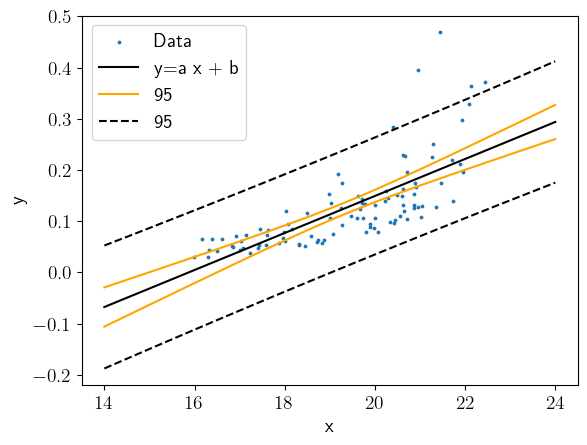

In [153]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt    
from scipy import stats
import pandas as pd

# pip install uncertainties, if needed
try:
    import uncertainties.unumpy as unp
    import uncertainties as unc
except:
    try:
        from pip import main as pipmain
    except:
        from pip._internal import main as pipmain
    pipmain(['install','uncertainties'])
    import uncertainties.unumpy as unp
    import uncertainties as unc

# import data
url = 'http://apmonitor.com/che263/uploads/Main/stats_data.txt'
data = pd.read_csv(url)
x = data['x'].values
y = data['y'].values
n = len(y)

def f(x, a, b):
    return a * x + b

popt, pcov = curve_fit(f, x, y)

# retrieve parameter values
a = popt[0]
b = popt[1]
print('Optimal Values')
print('a: ' + str(a))
print('b: ' + str(b))

# compute r^2
r2 = 1.0-(sum((y-f(x,a,b))**2)/((n-1.0)*np.var(y,ddof=1)))
print('R^2: ' + str(r2))

# calculate parameter confidence interval
a,b = unc.correlated_values(popt, pcov)
print('Uncertainty')
print('a: ' + str(a))
print('b: ' + str(b))

# plot data
plt.scatter(x, y, s=3, label='Data')

# calculate regression confidence interval
px = np.linspace(14, 24, 100)
py = a*px+b
nom = unp.nominal_values(py)
std = unp.std_devs(py)

def predband(x, xd, yd, p, func, conf=0.95):
    # x = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

lpb, upb = predband(px, x, y, popt, f, conf=0.95)

# plot the regression
plt.plot(px, nom, c='black', label='y=a x + b')

# uncertainty lines (95% confidence)
plt.plot(px, nom - 1.96 * std, c='orange',\
         label='95% Confidence Region')
plt.plot(px, nom + 1.96 * std, c='orange')
# prediction band (95% confidence)
plt.plot(px, lpb, 'k--',label='95% Prediction Band')
plt.plot(px, upb, 'k--')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc='best')

# save and show figure
plt.savefig('regression.png')
plt.show()

# EXAMPLE (NON-LINEAR)
https://apmonitor.com/che263/index.php/Main/PythonRegressionStatisticshttps://apmonitor.com/che263/index.php/Main/PythonRegressionStatistics

Optimal Values
a: 2.1445277114117273e-06
b: 0.5282518993436528
c: 0.0429585100297938
R^2: 0.6188720440634128
Uncertainty
a: (2+/-5)e-06
b: 0.53+/-0.11
c: 0.043+/-0.018


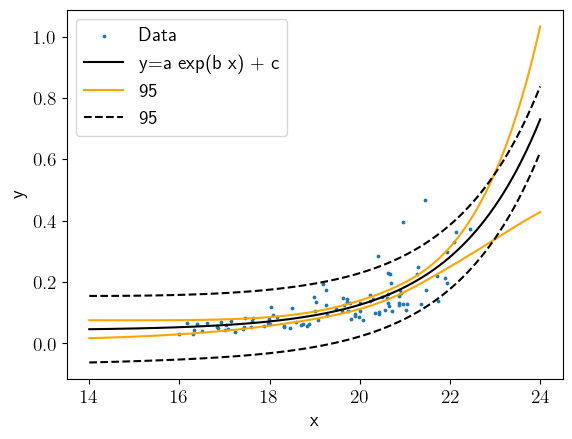

In [189]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt    
from scipy import stats
import pandas as pd

# pip install uncertainties, if needed
try:
    import uncertainties.unumpy as unp
    import uncertainties as unc
except:
    try:
        from pip import main as pipmain
    except:
        from pip._internal import main as pipmain
    pipmain(['install','uncertainties'])
    import uncertainties.unumpy as unp
    import uncertainties as unc

# import data
url = 'http://apmonitor.com/che263/uploads/Main/stats_data.txt'
data = pd.read_csv(url)
x = data['x'].values
y = data['y'].values
n = len(y)

def f(x, a, b, c):
    return a * np.exp(b*x) + c

popt, pcov = curve_fit(f, x, y)

# retrieve parameter values
a = popt[0]
b = popt[1]
c = popt[2]
print('Optimal Values')
print('a: ' + str(a))
print('b: ' + str(b))
print('c: ' + str(c))

# compute r^2
r2 = 1.0-(sum((y-f(x,a,b,c))**2)/((n-1.0)*np.var(y,ddof=1)))
print('R^2: ' + str(r2))

# calculate parameter confidence interval
a,b,c = unc.correlated_values(popt, pcov)
print('Uncertainty')
print('a: ' + str(a))
print('b: ' + str(b))
print('c: ' + str(c))

# plot data
plt.scatter(x, y, s=3, label='Data')

# calculate regression confidence interval
px = np.linspace(14, 24, 100)
py = a*unp.exp(b*px)+c
nom = unp.nominal_values(py)
std = unp.std_devs(py)

def predband(x, xd, yd, p, func, conf=0.95):
    # x = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

lpb, upb = predband(px, x, y, popt, f, conf=0.95)

# plot the regression
plt.plot(px, nom, c='black', label='y=a exp(b x) + c')

# uncertainty lines (95% confidence)
plt.plot(px, nom - 1.96 * std, c='orange',\
         label='95% Confidence Region')
plt.plot(px, nom + 1.96 * std, c='orange')
# prediction band (95% confidence)
plt.plot(px, lpb, 'k--',label='95% Prediction Band')
plt.plot(px, upb, 'k--')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc='best')

# save and show figure
plt.savefig('regression.png')
plt.show()

# CALCULATIONS

In [660]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt    
from scipy import stats
import pandas as pd

# pip install uncertainties, if needed
import uncertainties.unumpy as unp
import uncertainties as unc
from uncertainties import ufloat

from matplotlib import rcParams
# for pretty plotting
rcParams['ps.fonttype']=42
rcParams['pdf.fonttype']=42
rcParams['font.size']=13
rcParams['text.usetex']=True
rcParams['pgf.texsystem']='pdflatex'
rcParams['font.family']='sans-serif'
rcParams['font.serif']='cm'
rcParams["figure.figsize"] = (7,6)
rcParams["figure.dpi"] = 120
rcParams["axes.axisbelow"] = True #grid behind plot

## DATA

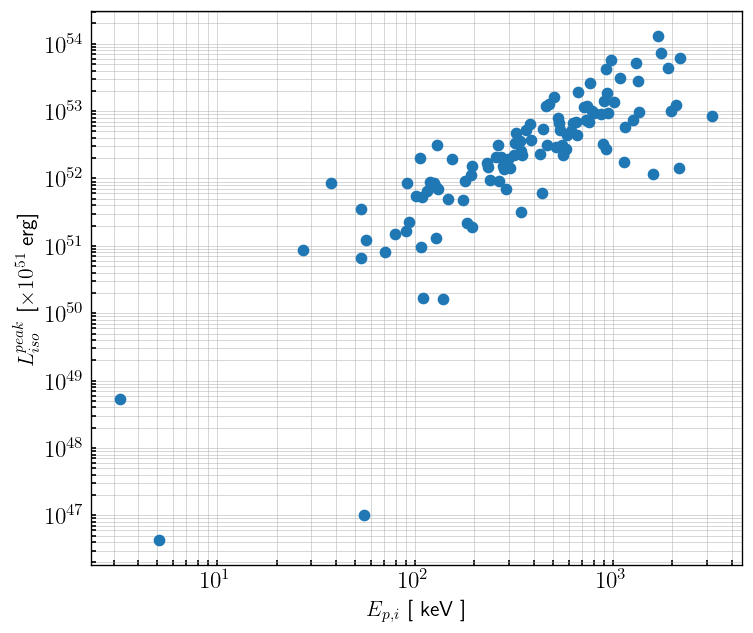

In [754]:
data = pd.read_csv('yonetoku_2010_table4.csv')
redshift = data["Redshift"].values
x = data["E_obs_p(keV)"].values * (1+redshift)
y = data["L_p(ergs−1)"].values
n=len(y)

plt.xscale('log')
plt.yscale('log')

plt.tick_params(direction='in', which='both', length=3, width=1, labelright=False, axis='both')
plt.minorticks_off
plt.grid(True, which='both', lw = 0.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(r'$L^{peak}_{iso}$  [$\times 10^{51}$ erg]')
plt.xlabel('$E_{p,i}$  [ keV ]')

plt.scatter(x, y,lw=1.0)#, s=2.0, color='green', zorder=2)

plt.show()

## CORRELATION (YONETOKU 2004)

$\dfrac{L_{peak}}{10^{52}erg~s^{-1}} = (2.34\pm2.29)\times10^{-5} \times [\dfrac{E_{peak,z}}{1keV}]^{2.0\mp0.2}$

$\color{steelblue}{L_{peak} = a \times E_{peak,z}^{b}}$

In [498]:
def luminosity_pl_yonetoku_2004(E_peak_z,a,b):
    """
    (Yonetoku, 2004) correlation between peak luminosity
    and peak energy.
    """
    return a*1e6 * E_peak_z**b

def luminosity_pl_yonetoku_2004_sig(E_peak_z,a,b):
    """
    (Yonetoku, 2004) correlation between peak luminosity
    and peak energy.
    """
    return (a*1e6+2.29e1) * E_peak_z**(b),(a*1e6-2.29e1) * E_peak_z**(b)
def luminosity_pl_yonetoku_2004_3sig(E_peak_z,a,b):
    """
    (Yonetoku, 2004) correlation between peak luminosity
    and peak energy.
    """
    return (a*1e6+3*2.29e1) * E_peak_z**(b),(a*1e6-3*2.29e1) * E_peak_z**(b)

In [346]:
a_nom = 2.34e-5
b_nom = 2.0

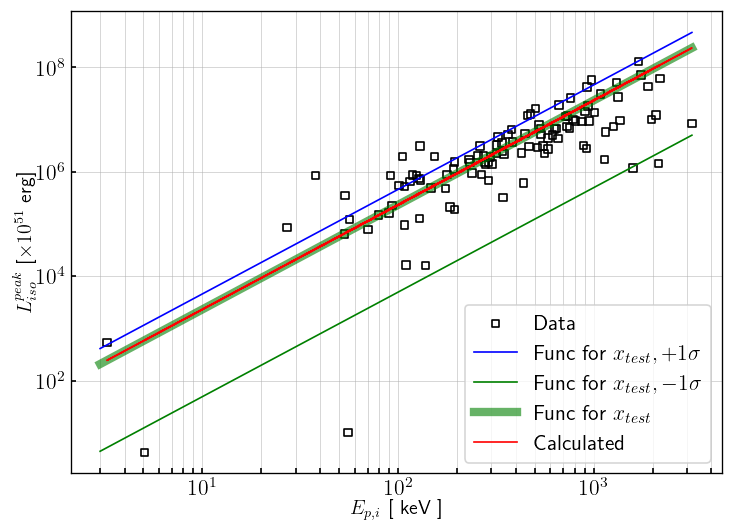

In [501]:
#PLOT PARAMETERS
plt.xscale('log')
plt.yscale('log')
plt.tick_params(direction='in', which='both', length=3, width=1, labelright=False, axis='both')
plt.minorticks_off
plt.grid(True, which='both', lw = 0.3)
plt.ylabel(r'$L^{peak}_{iso}$  [$\times 10^{51}$ erg]',fontsize=12, labelpad=0)
plt.xlabel('$E_{p,i}$  [ keV ]',fontsize=12,labelpad=0)

#CALCULATIONS
y_calc = luminosity_pl_yonetoku_2004(x,a_nom,b_nom)
px_check = np.linspace(int(x.min()), int(x.max()), len(y))
py_check_sig = luminosity_pl_yonetoku_2004_sig(px_check,a_nom,b_nom)
py_check_3sig = luminosity_pl_yonetoku_2004_3sig(px_check,a_nom,b_nom)
py_check = luminosity_pl_yonetoku_2004(px_check,a_nom,b_nom)

#PLOT
plt.scatter(x, y,lw=1.0, marker="s", s=20, facecolors='none', edgecolors='k',label="Data")
plt.plot(px_check, py_check_sig[0],lw=1.0,c="b", label=r"Func for $x_{test}, +1\sigma$")
plt.plot(px_check, py_check_sig[1],lw=1.0,c="g", label=r"Func for $x_{test}, -1\sigma$")
plt.plot(px_check, py_check,lw=5.0,c="g",alpha=0.6, label=r"Func for $x_{test}$")
plt.plot(x, y_calc,lw=1.0,c="r", label="Calculated")
#plt.axhline(1)
plt.legend()
plt.show()

### $R^2$

In [433]:
# compute r^2
r2 = 1.0-(sum((y-luminosity_pl_yonetoku_2004(x,a_nom,b_nom))**2)\
          /((n-1.0)*np.var(y,ddof=1)))
print('R^2: ' + str(r2))

R^2: -1.9125466894523075


In [227]:
def r_squared(func, coef, x, y):
    '''
    Коэффициент детерминации (R-квадрат)
    http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%D1%86%D0%B8%D0%B8
    '''
    y_mean = np.mean(y)
    tss = sum((y - y_mean)**2) # total sum of squares
    rss = sum((y - func(x,*coef))**2)#residual sum of squares
    return 1 - (rss / tss)

r2 = r_squared(luminosity_pl_yonetoku_2004,coef, x, y)
print('R^2: ' + str(r2))

R^2: -1.8159334310485007


In [347]:
# calculate parameter confidence interval
a = ufloat(a_nom, 2.29e-5)
b = ufloat(b_nom, 0.2)

coef = np.array([a_nom,b_nom])

print('Uncertainty')
print('a: ' + str(a))
print('b: ' + str(b))

Uncertainty
a: (2.3+/-2.3)e-05
b: 2.00+/-0.20


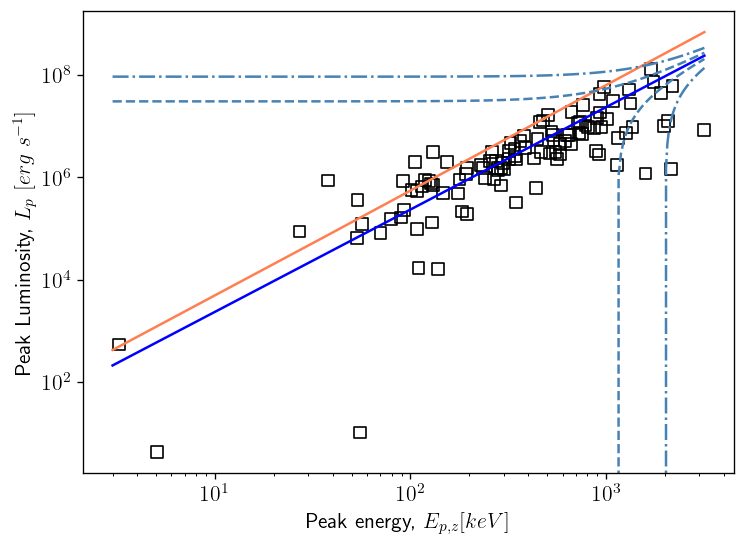

In [502]:
# plot data
def predband(x, xd, yd, p, func, conf=0.95):
    """
    x = requested points
    xd = x data
    yd = y data
    p = parameters
    func = function name
    """
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

plt.scatter(x, y,lw=1.0, marker="s", s=50, facecolors='none', edgecolors='k',label="Data")

# calculate regression confidence interval
px = np.linspace(int(x.min()), int(x.max()), 100)
py = luminosity_pl_yonetoku_2004(px,a,b)
nom = unp.nominal_values(py) #without uncertainties
std = unp.std_devs(py)

lpb_1, upb_1 = predband(px, x, y, coef, luminosity_pl_yonetoku_2004, conf=0.68)
lpb_3, upb_3 = predband(px, x, y, coef, luminosity_pl_yonetoku_2004, conf=0.997)

# plot the regression
plt.plot(px, nom, c='blue', label='Function')#r'$y=(2.34 \pm 2.29) \times 10^{-5} \times x^{2 \pm 0.2}$')
#plt.plot(px, luminosity_pl_yonetoku_2004(px,a_nom,b_nom), c='green', label='Function')
## uncertainty lines (95% confidence)
#plt.plot(px, nom - std, c='orange',label=r'99.7\% Confidence Region')
plt.plot(px, nom + std, c='coral')
plt.plot(px, lpb_1, '--', c="steelblue",label='$1\sigma$ Prediction Band')
plt.plot(px, lpb_3, '-.', c="steelblue",label='$3\sigma$ Prediction Band')
plt.plot(px, upb_1, '--', c="steelblue")
plt.plot(px, upb_3, '-.', c="steelblue")


plt.xlabel(r'Peak energy, $E_{p,z} [keV]$')
plt.ylabel(r'Peak Luminosity, $L_{p}~[erg~s^{-1}]$')
#plt.legend(loc='best')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(3,3000)
#plt.ylim(10,1e2)
# save and show figure
plt.show()

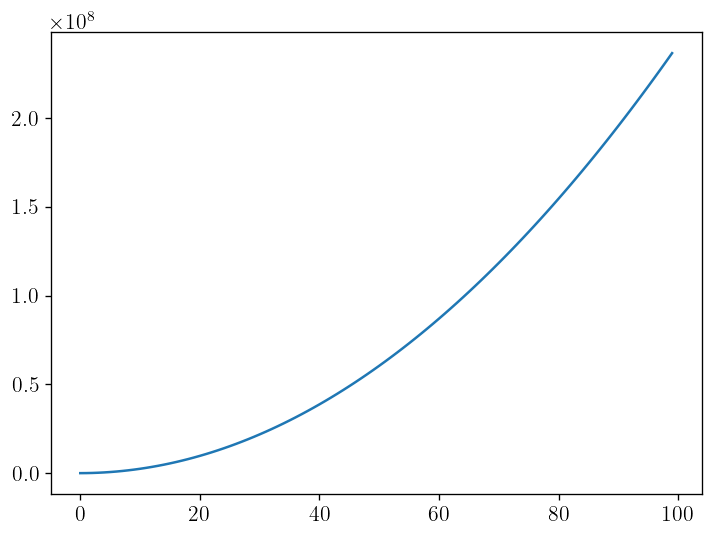

In [505]:
plt.plot(nom)

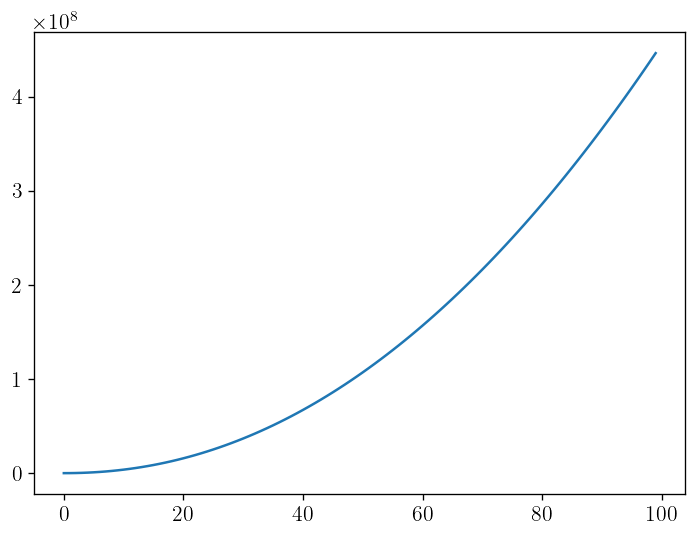

In [506]:
plt.plot(std)

## CORRELATION (YONETOKU 2010)

$\dfrac{L_{peak}}{10^{52}erg~s^{-1}} = (10^{0.43\pm0.037})\times [\dfrac{E_{peak,z}}{355 keV}]^{1.6\mp0.082}$

$\color{steelblue}{L_{peak} = 10^a \times [\dfrac{E_{peak,z}}{355 keV}]^{b}}$

In [668]:
def luminosity_pl_yonetoku_2010(E_peak_z,a,b):
    """
    (Yonetoku, 2004) correlation between peak luminosity
    and peak energy.
    """
    return 10**a * (E_peak_z/355)**b

def luminosity_pl_yonetoku_2010_sig(E_peak_z,a,b):
    """
    (Yonetoku, 2004) correlation between peak luminosity
    and peak energy.
    """
    return 10**(a+0.33)*(E_peak_z/355)**b, 10**(a-0.33)*(E_peak_z/355)**b

def luminosity_pl_yonetoku_2010_3sig(E_peak_z,a,b):
    """
    (Yonetoku, 2004) correlation between peak luminosity
    and peak energy.
    """
    return 10**(a+3*0.33)*(E_peak_z/355)**b, 10**(a-3*0.33)*(E_peak_z/355)**b

In [669]:
a_nom = 52.43
b_nom = 1.6

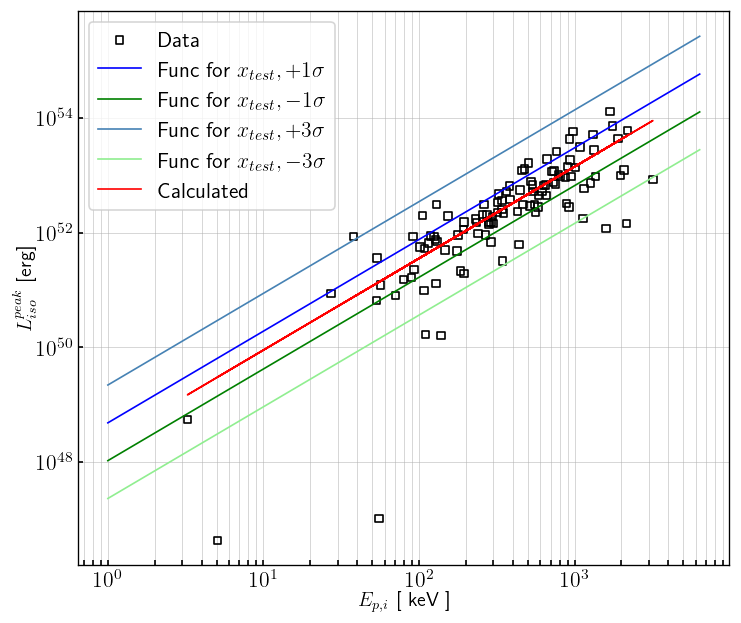

In [713]:
#PLOT PARAMETERS
plt.xscale('log')
plt.yscale('log')
plt.tick_params(direction='in', which='both', length=3, width=1, labelright=False, axis='both')
plt.minorticks_off
plt.grid(True, which='both', lw = 0.3)
plt.ylabel(r'$L^{peak}_{iso}$  [erg]',fontsize=12, labelpad=0)
plt.xlabel('$E_{p,i}$  [ keV ]',fontsize=12,labelpad=0)

#CALCULATIONS
y_calc = luminosity_pl_yonetoku_2010(x,a_nom,b_nom)

px_check = np.linspace(1, x.max()*2, 100)
py_check = luminosity_pl_yonetoku_2010(px_check,a_nom,b_nom)

py_check_sig = luminosity_pl_yonetoku_2010_sig(px_check,a_nom,b_nom)
py_check_3sig = luminosity_pl_yonetoku_2010_3sig(px_check,a_nom,b_nom)

#PLOT

plt.scatter(x, y,lw=1.0, marker="s", s=20, facecolors='none', edgecolors='k',label="Data")

#plt.plot(px_check,py_check,lw=5.0,c="g",alpha=0.6, label=r"Func for $x_{test}$")
plt.plot(px_check, py_check_sig[0], lw=1.0,c="b", label=r"Func for $x_{test}, +1\sigma$")
plt.plot(px_check, py_check_sig[1], lw=1.0,c="g", label=r"Func for $x_{test}, -1\sigma$")
plt.plot(px_check,py_check_3sig[0],lw=1.0,c="steelblue", label=r"Func for $x_{test}, +3\sigma$")
plt.plot(px_check,py_check_3sig[1],lw=1.0,c="lightgreen",label=r"Func for $x_{test}, -3\sigma$")
#plt.ylim(1e-3,1)
plt.plot(x, y_calc,lw=1.0,c="r", label="Calculated")
#plt.axhline(1)
plt.legend()
plt.show()

### $R^2$

In [601]:
len(y)

109

In [612]:
# compute r^2
r2 = 1.0-(sum((y-luminosity_pl_yonetoku_2010(x,a_nom,b_nom))**2)\
          /((n-1.0)*np.var(y,ddof=99)))
print('R^2: ' + str(r2))

R^2: 0.920863124479225


In [531]:
def r_squared(func, coef, x, y):
    '''
    Коэффициент детерминации (R-квадрат)
    http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%D1%86%D0%B8%D0%B8
    '''
    y_mean = np.mean(y)
    tss = sum((y - y_mean)**2) # total sum of squares
    rss = sum((y - func(x,*coef))**2)#residual sum of squares
    return 1 - (rss / tss)

r2 = r_squared(luminosity_pl_yonetoku_2010,coef, x, y)
print('R^2: ' + str(r2))

R^2: 0.14532174437562995


In [614]:
np.corrcoef(y_calc,y)

array([[1.        , 0.47809673],
       [0.47809673, 1.        ]])

In [700]:
# calculate parameter confidence interval
a = ufloat(a_nom, 0.037)
b = ufloat(b_nom, 0.082)

coef = np.array([a_nom,b_nom])

print('Uncertainty')
print('a: ' + str(a))
print('b: ' + str(b))

Uncertainty
a: 52.43+/-0.04
b: 1.60+/-0.08


In [646]:
print("dispersion = ",np.var(np.log10(y)))
print("std = ",np.std(np.log10(y)))

dispersion =  1.2489750984273502
dispersion =  1.1175755448413096
std =  1.1175755448413096


In [723]:
1e49-1e48

9e+48

In [721]:
np.arange(1e47,1e54,1000)

ValueError: Maximum allowed size exceeded

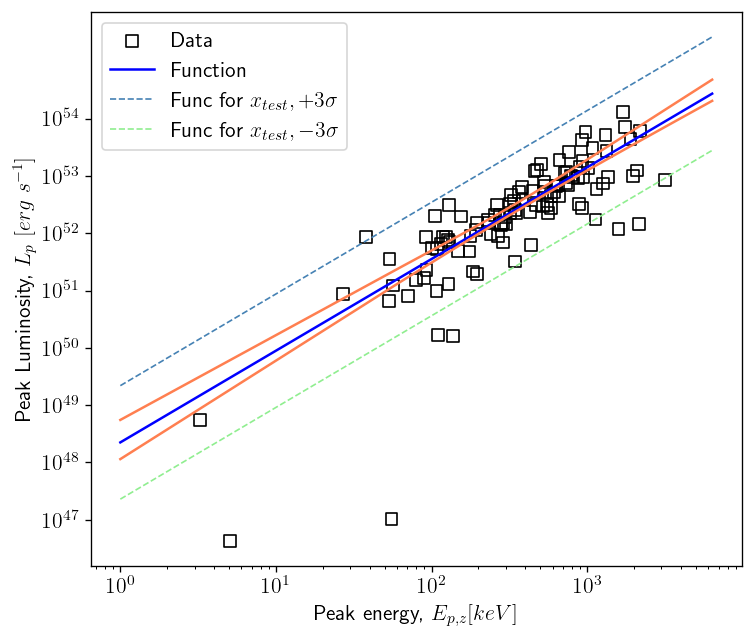

In [769]:
plt.scatter(x, y,lw=1.0, marker="s", s=50, facecolors='none', edgecolors='k',label="Data")

# calculate regression confidence interval
px = np.linspace(1, x.max()*2, 100)
py = luminosity_pl_yonetoku_2010(px,a,b)
nom = unp.nominal_values(py) #without uncertainties
std = unp.std_devs(py)

# plot the regression
plt.plot(px, nom, c='blue', label='Function')

## uncertainty lines (95% confidence)
plt.plot(px, (nom + 3*std), c='coral')
plt.plot(px, (nom - std), c='coral')

plt.plot(px_check,py_check_3sig[0],lw=1.0,ls='--',c="steelblue", label=r"Func for $x_{test}, +3\sigma$")
plt.plot(px_check,py_check_3sig[1],lw=1.0,ls='--',c="lightgreen",label=r"Func for $x_{test}, -3\sigma$")

#lcb,ucb,x_linspace=confband(x,y,a_nom,b_nom,conf=0.997,x_=None)
#
#plt.plot(x_linspace,lcb,label="LCB")

plt.xlabel(r'Peak energy, $E_{p,z} [keV]$')
plt.ylabel(r'Peak Luminosity, $L_{p}~[erg~s^{-1}]$')
plt.legend(loc='best')
plt.xscale('log')
plt.yscale('log')
plt.yticks([1e47,1e48,1e49,1e50,1e51,1e52,1e53,1e54])
#plt.xlim(2,4e3)
#plt.axhline(0)
#plt.ylim(2e46,2e54)
# save and show figure
plt.show()

In [759]:
def scatterfit(x,y,a=None,b=None):  
    """  
    Compute the mean deviation of the data about the linear model given if A,B  
    (y=ax+b) provided as arguments. Otherwise, compute the mean deviation about   
    the best-fit line.  

    x,y assumed to be np arrays. a,b scalars.  
    Returns the float sd with the mean deviation.  

    Author: Rodrigo Nemmen  
    """  

    if a==None:   
    # Performs linear regression  
        a, b, r, p, err = stats.linregress(x,y)  

    # Std. deviation of an individual measurement (Bevington, eq. 6.15)  
    N=np.size(x)  
    sd=1./(N-2.)* np.sum((y-a*x-b)**2); sd=np.sqrt(sd)  

    return sd 
def confband(xd,yd,a,b,conf=0.95,x_=None):
	"""
    Calculates the confidence band of the linear regression model at the desired confidence
    level, using analytical methods. The 2sigma confidence interval is 95% sure to contain 
    the best-fit regression line. This is not the same as saying it will contain 95% of 
    the data points.
    Arguments:
    - conf: desired confidence level, by default 0.95 (2 sigma)
    - xd,yd: data arrays
    - a,b: linear fit parameters as in y=ax+b
    - x: (optional) array with x values to calculate the confidence band. If none is provided, will
      by default generate 100 points in the original x-range of the data.

    Returns:
    Sequence (lcb,ucb,x) with the arrays holding the lower and upper confidence bands 
    corresponding to the [input] x array.
    Usage:
    >>> lcb,ucb,x=nemmen.confband(all.kp,all.lg,a,b,conf=0.95)
    calculates the confidence bands for the given input arrays
    >>> pylab.fill_between(x, lcb, ucb, alpha=0.3, facecolor='gray')
    plots a shaded area containing the confidence band
    References:
    1. http://en.wikipedia.org/wiki/Simple_linear_regression, see Section Confidence intervals
    2. http://www.weibull.com/DOEWeb/confidence_intervals_in_simple_linear_regression.htm
    Author: Rodrigo Nemmen
    v1 Dec. 2011
    v2 Jun. 2012: corrected bug in computing dy
	"""
	alpha=1.-conf	# significance
	n=xd.size	# data sample size

	if x_==None: x_=np.linspace(xd.min(),xd.max(),100)

	# Predicted values (best-fit model)
	y=a*x_+b

	# Auxiliary definitions
	sd=scatterfit(xd,yd,a,b)	# Scatter of data about the model
	sxd=np.sum((xd-xd.mean())**2)
	sx=(x_-xd.mean())**2	# array

	# Quantile of Student's t distribution for p=1-alpha/2
	q=stats.t.ppf(1.-alpha/2.,n-2)

	# Confidence band
	dy=q*sd*np.sqrt( 1./n + sx/sxd )
	ucb=y+dy	# Upper confidence band
	lcb=y-dy	# Lower confidence band

	return lcb,ucb,x_

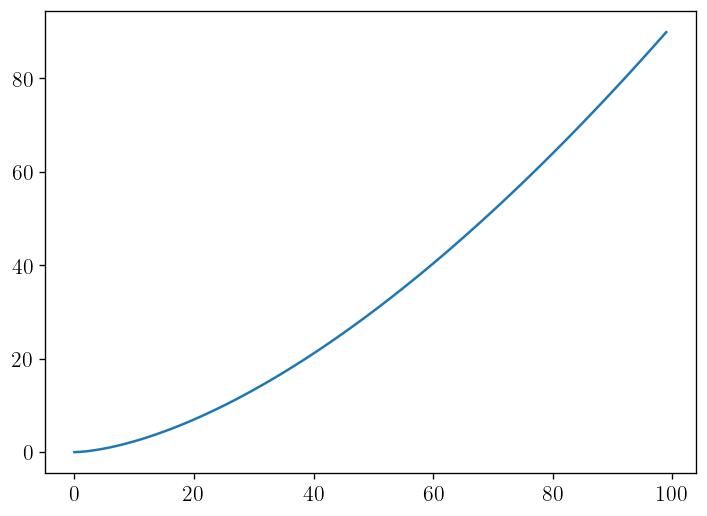

In [554]:
plt.plot(nom)

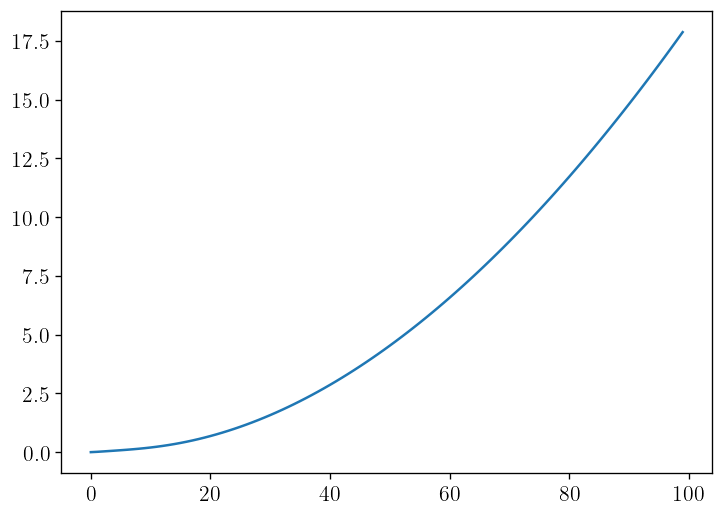

In [555]:
plt.plot(std)

# CHECK

### NOMINAL VALUES == CALCULATED VALUE -- $\color{green}{\text{TRUE}}$
### THE FUNCTION

 
[ True  True  True  True  True  True  True  True  True  True]
 


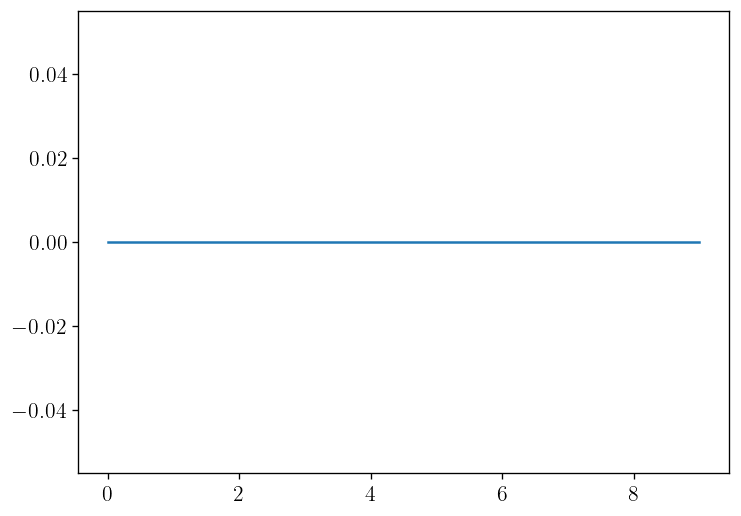

In [387]:
px_check = np.linspace(int(x.min()), int(x.max()), 10)
py_check = luminosity_pl_yonetoku_2004(px_check,a_nom,b_nom)

px = np.linspace(int(x.min()), int(x.max()), 10)
py = luminosity_pl_yonetoku_2004(px,a,b)
nom = unp.nominal_values(py) #without uncertainties
print(" ")
print(py_check==nom)
print(" ")
plt.plot(py_check-nom);

### NOMINAL VALUES == CALCULATED VALUE -- $\color{green}{\text{TRUE}}$
### LIGHT FUNCTION

 
[ True  True  True  True  True  True  True  True  True  True]
 


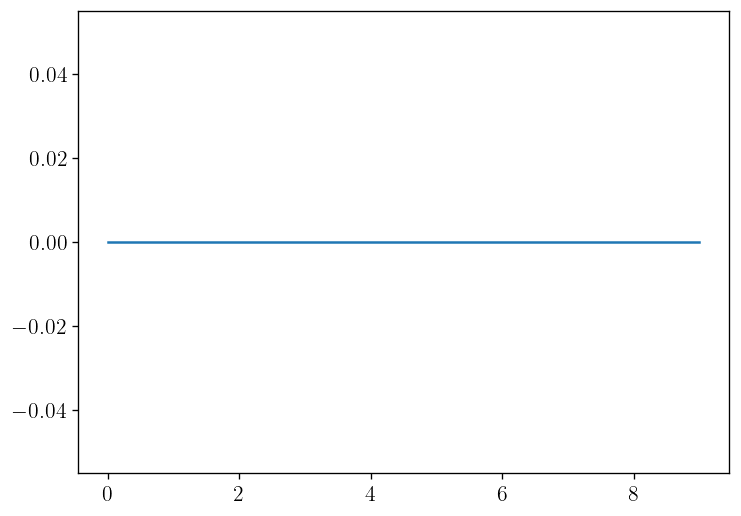

In [325]:
# calculate parameter confidence interval
def func(x,c1,c2):
    return c1*x**c2

x=np.arange(1,11)
c1 = ufloat(10.3, 10)
c2 = ufloat(2.1, 0.1)

y = func(x,c1,c2)
y_nom = unp.nominal_values(y)
x_calc = np.linspace(int(x.min()), int(x.max()), 10)
y_calc = func(x_calc,c1.nominal_value,c2.nominal_value)
print(" ")
print(y_calc==y_nom)
print(" ")
plt.plot(y_calc-y_nom);